<a href="https://colab.research.google.com/github/naguzmans/opportunistic-atm/blob/master/conv_lstm_3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [2]:
import glob

folder_path = '/content/drive/MyDrive/opportunistic-utm/dataset/'
folder_list = []
for folder in glob.iglob(folder_path + '/**/**/', recursive=False):
  folder_list.append(folder)

In [ ]:
folder_list

**Load Traffic Data**

In [ ]:
import numpy as np
from tqdm import tqdm
%config InlineBackend.figure_format = 'retina'

day_array = []
for folder in tqdm(folder_list):
  files = np.sort(glob.glob(folder + '/*.npy', recursive=False))
  hours_array = np.expand_dims(np.moveaxis(np.load(files[0]), 0, -1), 0)

  for i in range(1, 24):
    next_hour = np.expand_dims(np.moveaxis(np.load(files[i]), 0, -1), 0)
    hours_array = np.concatenate((hours_array, next_hour), axis=0)

  day_array.append(hours_array)

day_array = np.array(day_array)
day_array.shape

In [ ]:
# Save day array
np.save(f'{folder_path}day_array.npy', day_array)

In [3]:
# Load day array
import numpy as np
day_array = np.load(f'{folder_path}day_array.npy')
day_array.shape

(59, 24, 100, 100, 20)

**Load Metadata**

In [169]:
import numpy as np
from tqdm import tqdm
%config InlineBackend.figure_format = 'retina'

metadata_array = []
for folder in tqdm(folder_list):
  files = np.sort(glob.glob(folder + 'metadata/*.npy', recursive=False))
  hours_array = np.expand_dims(np.load(files[0]), 0)

  for i in range(1, 24):
    next_hour = np.expand_dims(np.load(files[i]), 0)
    hours_array = np.concatenate((hours_array, next_hour), axis=0)

  metadata_array.append(hours_array)

metadata_array = np.array(metadata_array)
metadata_array.shape

100%|██████████| 59/59 [03:29<00:00,  3.55s/it]


(59, 24, 25)

In [ ]:
# Save metadata array
np.save(f'{folder_path}metadata_array.npy', metadata_array)

In [166]:
# Load metadata array
import numpy as np
metadata_array = np.load(f'{folder_path}metadata_array.npy')
metadata_array.shape

(59, 24, 24)

**Flights Average**

In [4]:
from tqdm import tqdm
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Flights average
flights_average = np.zeros([day_array.shape[2], day_array.shape[3], day_array.shape[-1]]) # (100, 100, 20)
for channel in tqdm(range(0, day_array.shape[-1])): # iterate channels
  for day in range(0, day_array.shape[0]): # iterate days
    flights_average[:, :, channel] += np.sum(day_array[day, :, :, :, channel], axis=0)

flights_average /= (day_array.shape[0] * day_array.shape[1]) # total_days x total_hours
flights_average = np.where(flights_average > 0.01, 1, 0)

100%|██████████| 20/20 [00:03<00:00,  6.16it/s]


In [5]:
def flatten_array(input_array):
  len_array = input_array.shape[-1]
  levels_array = []
  for i in range(0, len_array):
    level = input_array[:, :, i]*((i+1)/len_array)
    levels_array.append(level)
  
  levels_array = np.array(levels_array)
  levels_array = np.moveaxis(levels_array, 0, -1)

  return np.amax(levels_array, axis=2)

Level 0: 179
Level 1: 158
Level 2: 166
Level 3: 166
Level 4: 170
Level 5: 195
Level 6: 191
Level 7: 189
Level 8: 188
Level 9: 167
Level 10: 145
Level 11: 107
Level 12: 56
Level 13: 7
Level 14: 1
Level 15: 0
Level 16: 0
Level 17: 0
Level 18: 0
Level 19: 0


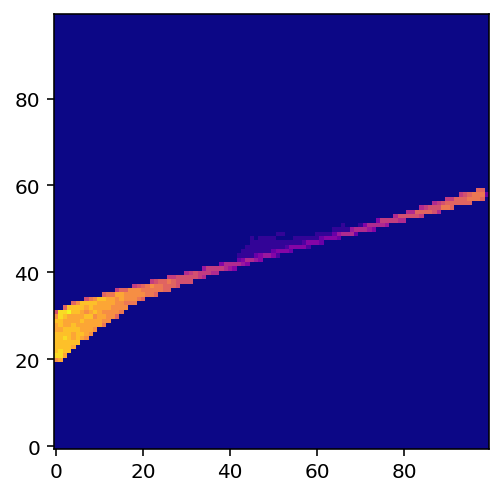

In [6]:
for i in range(0, flights_average.shape[-1]):
  print(f'Level {i}: {np.sum(flights_average[:,:,i])}')

flatten_average = flatten_array(flights_average)
plt.imshow(flatten_average, origin='lower', cmap = plt.get_cmap('plasma'))
plt.show()

In [87]:
import numpy as np
np.set_printoptions(precision=1)

def SARMSE(original, predicted):
  layer_rmse = np.sqrt(np.sum(np.square(original-predicted)/100**2, axis=(0,1)))
  return np.sum(layer_rmse)/original.shape[-1] # divided by # of channels

# Tests
a = np.expand_dims(np.zeros([100,100]), -1)
b = np.expand_dims(np.ones([100,100]), -1)
c = np.stack([np.zeros([100,100]), np.zeros([100,100])], -1)
d = np.stack([np.ones([100,100]), np.ones([100,100])], -1)

# print(RMSE(a,b,0,1))
# print(RMSE(a,a,0,1))
# print(RMSE(b,b,0,1))

# print(RMSE(c,d))
# print(RMSE(c,c,0,2))
# print(RMSE(d,d,0,2))

In [86]:
import random

sum = 0
random_days = random.sample(range(59), 10)
print(f'Random Days: {random_days}')
for i in random_days:
  random_hours = random.sample(range(24), 10)
  print(f'Random Hours: {random_hours}')
  for j in random_hours:
    sum += SARMSE(day_array[i, j, :, :, :], flights_average)

print(f'SARMSE: {sum/100}')

Random Days: [33, 29, 13, 48, 19, 52, 35, 42, 9, 16]
Random Hours: [13, 5, 18, 17, 0, 7, 8, 4, 12, 1]
Random Hours: [21, 16, 2, 5, 1, 10, 9, 22, 7, 6]
Random Hours: [0, 8, 10, 11, 5, 12, 17, 16, 18, 1]
Random Hours: [17, 0, 15, 18, 22, 14, 19, 10, 5, 1]
Random Hours: [22, 1, 21, 6, 2, 16, 8, 9, 5, 10]
Random Hours: [7, 1, 4, 12, 16, 3, 0, 11, 23, 14]
Random Hours: [9, 3, 21, 19, 15, 2, 0, 22, 6, 5]
Random Hours: [20, 0, 3, 12, 10, 4, 17, 11, 2, 16]
Random Hours: [9, 5, 18, 20, 8, 6, 23, 4, 1, 17]
Random Hours: [12, 19, 8, 3, 22, 5, 23, 15, 11, 14]
SARMSE: 0.07904051939400554


**Visualization**


In [36]:
# 2D Visualization
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
%config InlineBackend.figure_format = 'retina'

def level_transform(input_array, hour):
  levels_array = []
  len_array = input_array[hour, ...].shape[-1]
  for i in range(0, len_array):
    level = input_array[hour, ..., i]*((i+2)/len_array)
    levels_array.append(level)
  
  levels_array = np.array(levels_array)
  levels_array = np.moveaxis(levels_array, 0, -1)

  return np.amax(levels_array, axis=2)


def browse_images(day_array):
    def view_hour(day, hour):
        plt.imshow(level_transform(day_array[day-1], hour), origin='lower', cmap = plt.get_cmap('plasma'))
        plt.show()
    interact(view_hour, day=widgets.IntSlider(min=1, max=day_array.shape[0], step=1, value=0), hour=widgets.IntSlider(min=0, max=23, step=1, value=0))

browse_images(day_array)

interactive(children=(IntSlider(value=1, description='day', max=59, min=1), IntSlider(value=0, description='ho…

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

def browse_images(day_array):
    def view_hour(day):
      fig, ax = plt.subplots(6, 4, figsize=(15, 15))
      for idx, ax in enumerate(ax.flat):
        ax.imshow(level_transform(day_array[day-1], idx), origin='lower', cmap = plt.get_cmap('plasma'))
        ax.set_title(f'Day {day} / Hour {idx}')
        ax.axis("off")
    
    interact(view_hour, day=widgets.IntSlider(min=1, max=day_array.shape[0], step=1, value=0))

browse_images(day_array)

interactive(children=(IntSlider(value=1, description='day', max=59, min=1), Output()), _dom_classes=('widget-i…

In [ ]:
# 3D Visualization
import plotly.graph_objects as go
import pandas as pd
import random

def ms(x, y, z, radius, resolution=5):
  u, v = np.mgrid[0:2*np.pi:resolution*2j, 0:np.pi:resolution*1j]
  X = radius * np.cos(u)*np.sin(v) + x
  Y = radius * np.sin(u)*np.sin(v) + y
  Z = radius * np.cos(v) + z
  return (X, Y, Z)

# Append spheres
day = 14
hour = 8

data = []
layers_df = pd.DataFrame(columns=['layer', 'x', 'y'])
cmap = plt.cm.get_cmap('plasma', 16)
for layer in range(0, day_array[day-1,...].shape[-1]): # looping layers
  layer_array = day_array[day-1, hour, ..., layer]
  
  for i in range(0, layer_array.shape[0]):
    for j in range(0, layer_array.shape[1]):
      if layer_array[i,j] == 1:
        layers_df.loc[len(layers_df)] = [layer, j, i]

data.append(go.Scatter3d(
          x= layers_df['x'],
          y= layers_df['y'],
          z= layers_df['layer'],
          name='layers',
          mode='markers',
          marker=dict(color=layers_df['layer'],colorscale='Plasma')))

layout = go.Layout(scene=dict(
  xaxis = dict(range=[0, 100]),
  yaxis = dict(range=[0, 100]),
  zaxis = dict(range=[-1, 20])))
        
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0, y=-1, z=2)
)

fig = go.Figure(data=data, layout=layout)
fig.update_layout(scene_camera=camera)
fig.show()

# ConvLSTM

In [119]:
x_train = day_array[0:40]
y_train = day_array[1:41]

x_val = day_array[41:51]
y_val = day_array[42:52]

x_test = day_array[52:58]
y_test = day_array[53:59]

In [179]:
x_mtrain = metadata_array[0:40]
y_mtrain = metadata_array[1:41]

x_mval = metadata_array[41:51]
y_mval = metadata_array[42:52]

x_mtest = metadata_array[52:58]
y_mtest = metadata_array[53:59]

In [19]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, GRU, Dropout, TimeDistributed, MaxPooling3D

import io
import imageio

# Model 1

In [108]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

a = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

b = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(5, 5),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

c = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(1, 1),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

x = tf.keras.layers.Concatenate()([a, b, c])
x = TimeDistributed(layers.BatchNormalization())(x)
x = TimeDistributed(layers.Dropout(0.2))(x)

x = layers.ConvLSTM2D(
    filters=20,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="sigmoid",
    data_format='channels_last'
)(x)

model = keras.models.Model(inputs = [inp], outputs = x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, 100,   0           []                               
                                100, 20)]                                                         
                                                                                                  
 conv_lstm2d_15 (ConvLSTM2D)    (None, None, 100, 1  60032       ['input_5[0][0]']                
                                00, 32)                                                           
                                                                                                  
 conv_lstm2d_16 (ConvLSTM2D)    (None, None, 100, 1  57664       ['input_5[0][0]']                
                                00, 16)                                                     

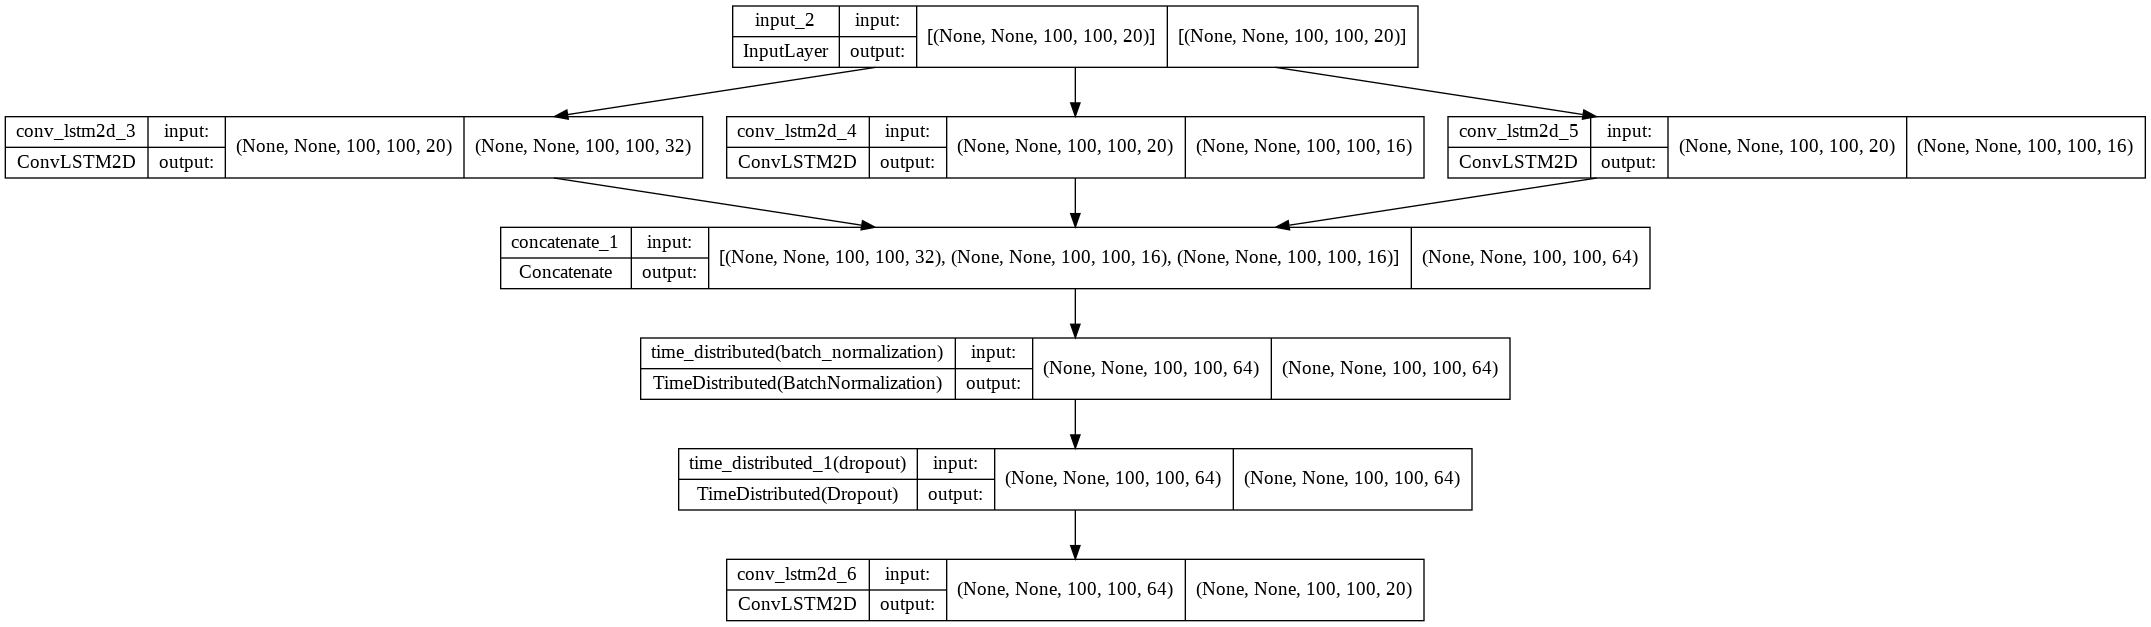

In [22]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Model 2

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
layer1 = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)

layer2 = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)

layer3 = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)

x = tf.keras.layers.Concatenate()([layer1, layer2, layer3])
# x = TimeDistributed(layers.BatchNormalization())(x)
# x = TimeDistributed(layers.Dropout(0.2))(x)

x = layers.Conv3D(
    filters=20, kernel_size=(3, 3, 3), activation="relu", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, 100,   0           []                               
                                100, 20)]                                                         
                                                                                                  
 conv_lstm2d_6 (ConvLSTM2D)     (None, None, 100, 1  166528      ['input_3[0][0]']                
                                00, 32)                                                           
                                                                                                  
 conv_lstm2d_7 (ConvLSTM2D)     (None, None, 100, 1  20800       ['input_3[0][0]']                
                                00, 16)                                                     

# Model 3

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(7, 7),
    padding="same",
    return_sequences=True,
    activation="tanh",
)(inp)
x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="tanh",
)(x)
x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=8,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="tanh",
)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv3D(
    filters=20, kernel_size=(10, 10, 10), activation="sigmoid", padding="same", data_format='channels_last'
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, None, 100, 100,   0         
                             20)]                                
                                                                 
 conv_lstm2d_40 (ConvLSTM2D)  (None, None, 100, 100, 3  326272   
                             2)                                  
                                                                 
 batch_normalization_34 (Bat  (None, None, 100, 100, 3  128      
 chNormalization)            2)                                  
                                                                 
 conv_lstm2d_41 (ConvLSTM2D)  (None, None, 100, 100, 1  76864    
                             6)                                  
                                                                 
 batch_normalization_35 (Bat  (None, None, 100, 100, 1  64

# Model 4


In [181]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))
minp = layers.Input(shape=(None, *x_mtrain.shape[2:]))

def repeat_tabular(x_tab):
  h = x_tab[:, :, :, None, None]
  h = tf.tile(h, [1, 1, 4, 100, 1]) 
  return h

a = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

b = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(5, 5),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

c = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(1, 1),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

y = tf.keras.layers.LSTM(64, return_sequences=True)(minp)
y = layers.Lambda(repeat_tabular)(minp)

x = tf.keras.layers.Concatenate()([a, b, c, y])
x = TimeDistributed(layers.BatchNormalization())(x)
x = TimeDistributed(layers.Dropout(0.2))(x)

x = layers.ConvLSTM2D(
    filters=20,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="sigmoid",
    data_format='channels_last'
)(x)

model = keras.models.Model(inputs = [inp, minp], outputs = x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, None, 100,   0           []                               
                                100, 20)]                                                         
                                                                                                  
 input_38 (InputLayer)          [(None, None, 25)]   0           []                               
                                                                                                  
 conv_lstm2d_69 (ConvLSTM2D)    (None, None, 100, 1  60032       ['input_37[0][0]']               
                                00, 32)                                                           
                                                                                            

# Custom Loss Function

In [160]:
def custom_loss_function(y_true, y_pred):
   squared_difference = tf.square(y_true - y_pred)
   return tf.reduce_mean(squared_difference, axis=-1)

# Training Single Input

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 30
batch_size = 5

# Fit the model to the training data.
history = model.fit(
    x= [x_train],
    y= [y_train],
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([x_val], y_val),
    callbacks=[early_stopping, reduce_lr],
)


# Training Dual Input

In [182]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 100
batch_size = 5

# Fit the model to the training data.
history = model.fit(
    x= [x_train, x_mtrain],
    y= [y_train, y_mtrain],
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([x_val, x_mval], y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/100
8/8 [==============================] - 14s 1s/step - loss: 0.3681 - val_loss: 0.3108 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 7s 886ms/step - loss: 0.2594 - val_loss: 0.2649 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 7s 889ms/step - loss: 0.1716 - val_loss: 0.2445 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - 7s 884ms/step - loss: 0.1242 - val_loss: 0.2124 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 7s 890ms/step - loss: 0.0975 - val_loss: 0.1820 - lr: 0.0010
Epoch 6/100
8/8 [==============================] - 7s 886ms/step - loss: 0.0778 - val_loss: 0.1624 - lr: 0.0010
Epoch 7/100
8/8 [==============================] - 7s 877ms/step - loss: 0.0635 - val_loss: 0.1428 - lr: 0.0010
Epoch 8/100
8/8 [==============================] - 7s 888ms/step - loss: 0.0512 - val_loss: 0.1211 - lr: 0.0010
Epoch 9/100
8/8 [==============================] - 7s 884ms/step - loss: 0.0390 - val_loss: 0.0938 - lr: 0

# Metrics

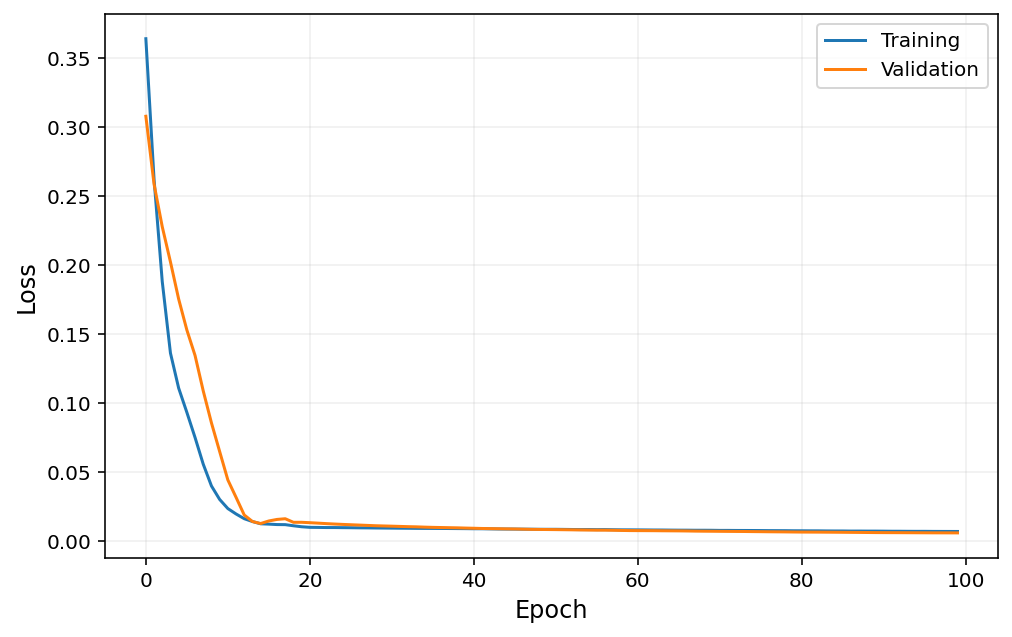

In [161]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('', fontweight='bold')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.legend(['Training', 'Validation'], loc='upper right')
plt.axis('on')
plt.grid('on', alpha=.2)
plt.show()

# Evaluation Single Input

In [ ]:
# Select a random example from the validation dataset.
example = x_test[0]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]
new_prediction = model.predict(np.expand_dims(frames, axis=0))
new_prediction = np.squeeze(new_prediction, axis=0)
predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
# predicted_frame = np.where(predicted_frame > 0.01, 1, 0)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(flatten_array(original_frames[0]), origin='lower', cmap = plt.get_cmap('plasma'))
ax[1].imshow(flatten_array(predicted_frame[0]), origin='lower', cmap = plt.get_cmap('plasma'))
print(f'SARMSE ConvLSTM Prediction: {SARMSE(original_frames[0], predicted_frame[0])}')
print(f'SARMSE Average Prediction: {SARMSE(original_frames[0], flights_average)}')

# Evaluation Dual Input


SARMSE ConvLSTM Prediction: 0.07587739462364458
SARMSE Average Prediction: 0.07880799910732299


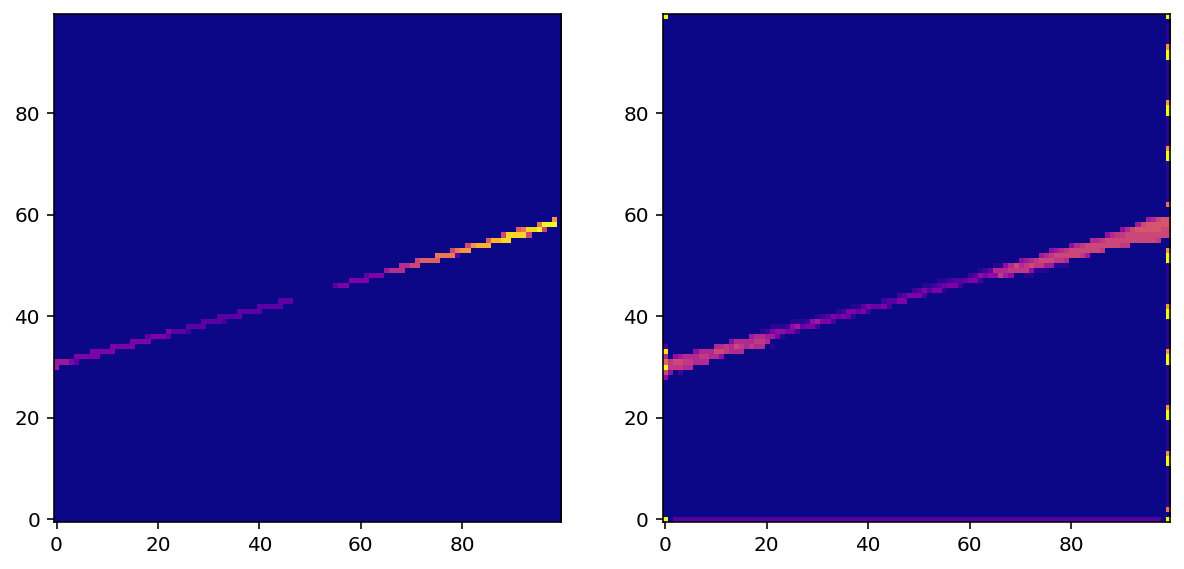

In [165]:
# Select a random example from the validation dataset.
day = 3
example = x_test[day]
mexample = x_mtest[day]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
mframes = mexample[:10, ...]
original_frames = example[10:, ...]
new_prediction = model.predict([np.expand_dims(frames, axis=0), np.expand_dims(mframes, axis=0)])
new_prediction = np.squeeze(new_prediction, axis=0)
predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
predicted_frame = np.where(predicted_frame > 0.01, 1, 0)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(flatten_array(original_frames[0]), origin='lower', cmap = plt.get_cmap('plasma'))
ax[1].imshow(flatten_array(predicted_frame[0]), origin='lower', cmap = plt.get_cmap('plasma'))
print(f'SARMSE ConvLSTM Prediction: {SARMSE(original_frames[0], predicted_frame[0])}')
print(f'SARMSE Average Prediction: {SARMSE(original_frames[0], flights_average)}')

# Multiple Prediction

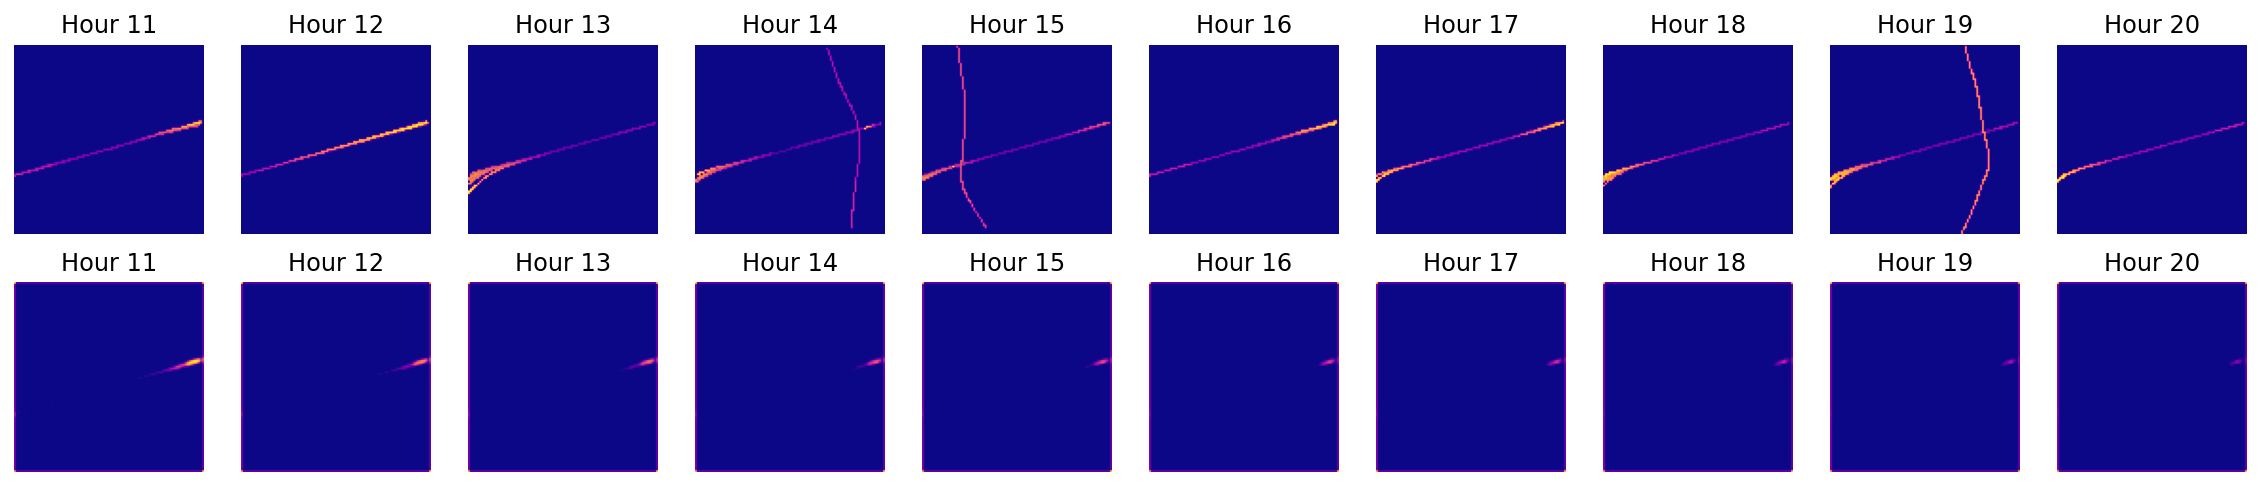

In [81]:
# Select a random example from the validation dataset.
example = x_test[1]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict([np.expand_dims(frames, axis=0)])
    # new_prediction[new_prediction > .5] = 1
    # new_prediction[new_prediction < .5] = 0

    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    # predicted_frame = np.where(predicted_frame > 0.01, 1, 0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
  
    ax.imshow(level_transform(original_frames, idx), origin='lower', cmap = plt.get_cmap('plasma'))
    # ax.imshow(np.amax(original_frames[idx], axis=2), origin='lower')
    ax.set_title(f"Hour {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(level_transform(new_frames, idx), origin='lower', cmap = plt.get_cmap('plasma'))
    # ax.imshow(np.amax(new_frames[idx], axis=2), origin='lower')
    ax.set_title(f"Hour {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

SARMSE_list = []
for i in range(0, new_frames.shape[0]):
  SARMSE_list.append(SARMSE(original_frames[i], new_frames[i]))

ax.plot(SARMSE_list, 'b*-')
ax.set_xlabel('Day')
ax.set_ylabel('SARMSE (%)')